In [27]:
#Ucitavanje biblioteka

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from kneed import KneeLocator
import time
from sklearn.preprocessing import StandardScaler, RobustScaler


In [28]:
#Ucitavanje csv fajla

data = pd.read_csv('songs_normalize.csv')
data.head(4)

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.355,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.612,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.251,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.347,0.544,119.992,"rock, metal"


In [29]:
#Izmjena naziva kolona, capslk

data.rename(columns={'artist':'Artist', 'song':'Song', 'duration_ms':'Duration_MS', 'explicit':'Explicit', 
                     'year':'Year','popularity':'Popularity','danceability':'Danceability',
                     'energy':'Energy', 'key':'Key', 'loudness':'Loudness', 'mode':'Mode', 
                     'speechiness':'Speechiness', 'acousticness':'Acousticness', 
                     'instrumentalness':'Instrumentalness', 'liveness':'Liveness', 
                     'valence':'Valence', 'tempo':'Tempo','genre':'Genre'},inplace=True)

In [30]:
#Duplikati

data.duplicated().sum()

59

In [31]:
#Brisanje duplikata

data.drop_duplicates(inplace=True)

In [32]:
#Koliko je pjesama izvan opsega 2000-2019

years_of_interest = [1999, 1998, 2020]
filtered_data = data[data['Year'].isin(years_of_interest)]

song_year = filtered_data['Year'].value_counts().reset_index()
song_year.columns = ['Year', 'Number of songs']

song_year

,Year,Number of songs
0,1999,38
1,2020,3
2,1998,1


In [33]:
#Posto nas zanimaju samo godine od 2000-2019, brisemo godine izvan tog opsega

data_years_drop = data[(data['Year'] <2000) | (data['Year'] > 2019)].index
data = data.drop(data_years_drop)
print(data.Year.unique())

[2000 2001 2011 2002 2016 2018 2004 2010 2015 2006 2008 2019 2003 2013
 2005 2012 2007 2009 2017 2014]


In [34]:
data.shape

(1899, 18)

In [35]:
filtered_data = data[data['Popularity'] > 0]

#Brisanje pjesama sa popularnoscu nula
data = filtered_data.reset_index(drop=True)


In [36]:
data.describe()

,Duration_MS,Year,Popularity,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
count,1773.000000,1773.000000,1773.000000,1773.000000,1773.000000,1773.000000,1773.000000,1773.000000,1773.000000,1773.000000,1773.000000,1773.000000,1773.000000,1773.000000
mean,228875.261139,2009.501974,63.791314,0.667528,0.720431,5.405527,-5.499287,0.551607,0.105158,0.128392,0.015383,0.182957,0.554581,120.049034
std,39512.716971,5.753360,15.279724,0.142146,0.152715,3.593748,1.938349,0.497470,0.097379,0.172774,0.088687,0.141414,0.219777,27.287712
min,113000.000000,2000.000000,1.000000,0.129000,0.054900,0.000000,-20.514000,0.000000,0.023200,0.000021,0.000000,0.021500,0.040600,60.019000
25%,204093.000000,2005.000000,58.000000,0.580000,0.624000,2.000000,-6.478000,0.000000,0.039900,0.014200,0.000000,0.089300,0.395000,98.020000
50%,223506.000000,2010.000000,67.000000,0.676000,0.736000,6.000000,-5.273000,1.000000,0.061800,0.055800,0.000000,0.127000,0.564000,120.014000
75%,248200.000000,2014.000000,74.000000,0.767000,0.838000,8.000000,-4.156000,1.000000,0.132000,0.176000,0.000062,0.243000,0.733000,134.966000
max,484146.000000,2019.000000,89.000000,0.975000,0.999000,11.000000,-0.276000,1.000000,0.576000,0.976000,0.985000,0.843000,0.973000,210.851000


In [37]:
#features = ['Energy','Acousticness', 'Valence', 'Instrumentalness', 'Tempo', 'Speechiness']
features = ['Energy','Acousticness', 'Valence', 'Instrumentalness', 'Tempo']

data['Tempo'] = (data['Tempo'] - data['Tempo'].min()) / (data['Tempo'].max() - data['Tempo'].min())
data['Loudness'] = (data['Loudness'] -data['Loudness'].min()) / (data['Loudness'].max() - data['Loudness'].min())
X = data[features]

scaler = MinMaxScaler()
X_scaled= scaler.fit_transform(X)
X_s = pd.DataFrame(X_scaled)
X_s.columns = features
X_s.index = data.index
X


,Energy,Acousticness,Valence,Instrumentalness,Tempo
0,0.834,0.3000,0.894,0.000018,0.232272
1,0.913,0.0263,0.544,0.000013,0.397615
2,0.928,0.0408,0.879,0.001040,0.746771
3,0.661,0.0302,0.760,0.000000,0.294931
4,0.772,0.0267,0.861,0.000000,0.285191
...,...,...,...,...,...
1768,0.734,0.0427,0.952,0.000000,0.516727
1769,0.702,0.1170,0.564,0.000021,0.729122
1770,0.678,0.0669,0.811,0.000000,0.251704
1771,0.520,0.4500,0.347,0.000002,0.284946


Najbolji Silhouette Score: 0.266 za broj klastera: 3


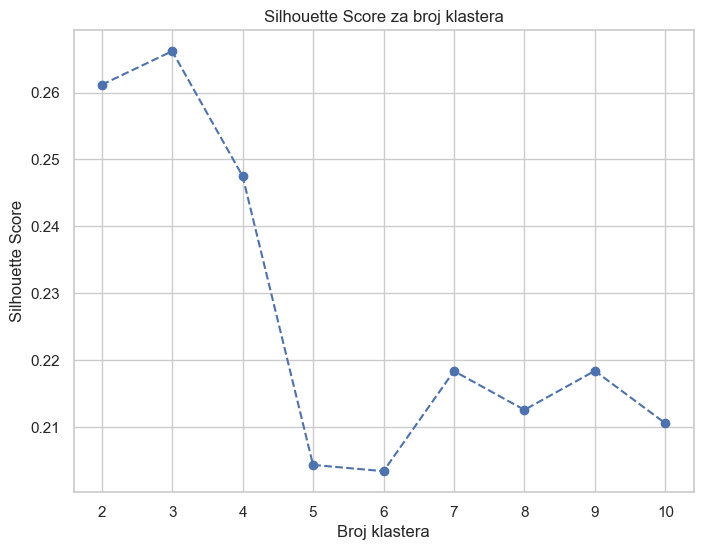

In [38]:
#Silhoutte score kmeans++

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)

silhouette_scores = []

for i in range(2, 11):
    kmeans=KMeans(n_clusters=i, init='k-means++', n_init = 10)
    labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

max_silhouette_score = max(silhouette_scores)
optimal_clusters = silhouette_scores.index(max_silhouette_score) + 2  

print(f"Najbolji Silhouette Score: {max_silhouette_score:.3f} za broj klastera: {optimal_clusters}")

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score za broj klastera')
plt.xlabel('Broj klastera')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

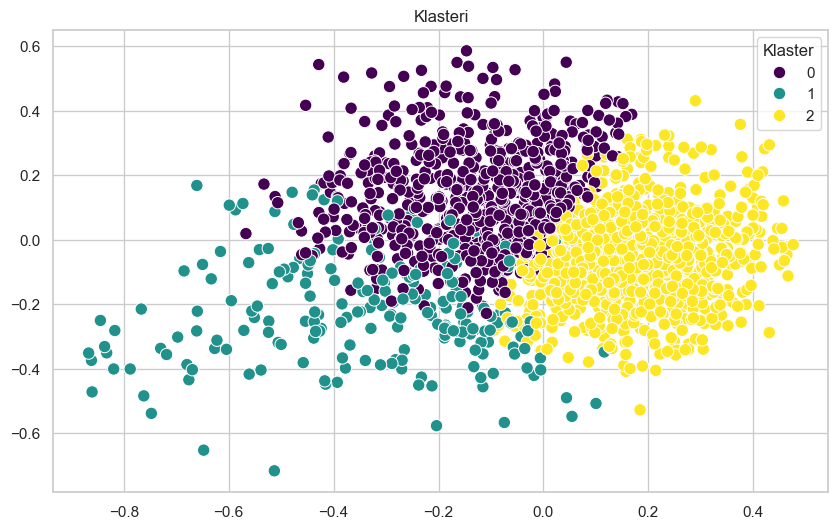

In [39]:


kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', n_init=10)
clusters = kmeans.fit_predict(X)
data['Cluster'] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['Cluster'], palette='viridis', s=80)
plt.title('Klasteri')
plt.legend(title='Klaster')
plt.show()

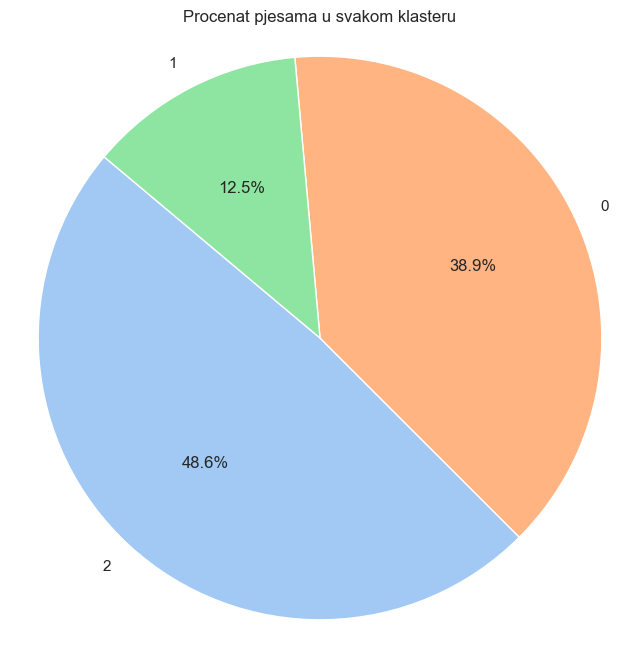

In [40]:
#Raposdjela pjesama

cluster_counts = data['Cluster'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel", len(cluster_counts)))
plt.title('Procenat pjesama u svakom klasteru')
plt.axis('equal')
plt.show()

In [41]:
cluster_means = data.groupby('Cluster')[features].mean()
cluster_means

,Energy,Acousticness,Valence,Instrumentalness,Tempo
Cluster,,,,,
0,0.712970,0.064514,0.370563,0.012317,0.439097
1,0.522973,0.483525,0.427900,0.017271,0.332381
2,0.777028,0.088475,0.734358,0.017353,0.381912


In [42]:

sorted_data = data.sort_values(by=['Cluster', 'Popularity'], ascending=[True, False])
grouped_data = sorted_data.groupby('Cluster')
top_songs_per_cluster = {}
for cluster, group in grouped_data:
    top_songs_per_cluster[cluster] = group.head(10)

for cluster, top_songs in top_songs_per_cluster.items():
    print(f"\nCluster {cluster}:")
    print(top_songs[['Song', 'Artist','Popularity']])



Cluster 0:
                                     Song             Artist  Popularity
1188                      Sweater Weather  The Neighbourhood          89
162                      'Till I Collapse             Eminem          85
1350                         Daddy Issues  The Neighbourhood          85
1510                              Perfect         Ed Sheeran          85
1349                            The Hills         The Weeknd          84
1424                            One Dance              Drake          84
1503                               No Lie          Sean Paul          84
1684  Lost in the Fire (feat. The Weeknd)      Gesaffelstein          84
10                             In the End        Linkin Park          83
64                                   Stan             Eminem          83

Cluster 1:
                      Song          Artist  Popularity
1179          Another Love       Tom Odell          88
1600  lovely (with Khalid)   Billie Eilish          86
1207    

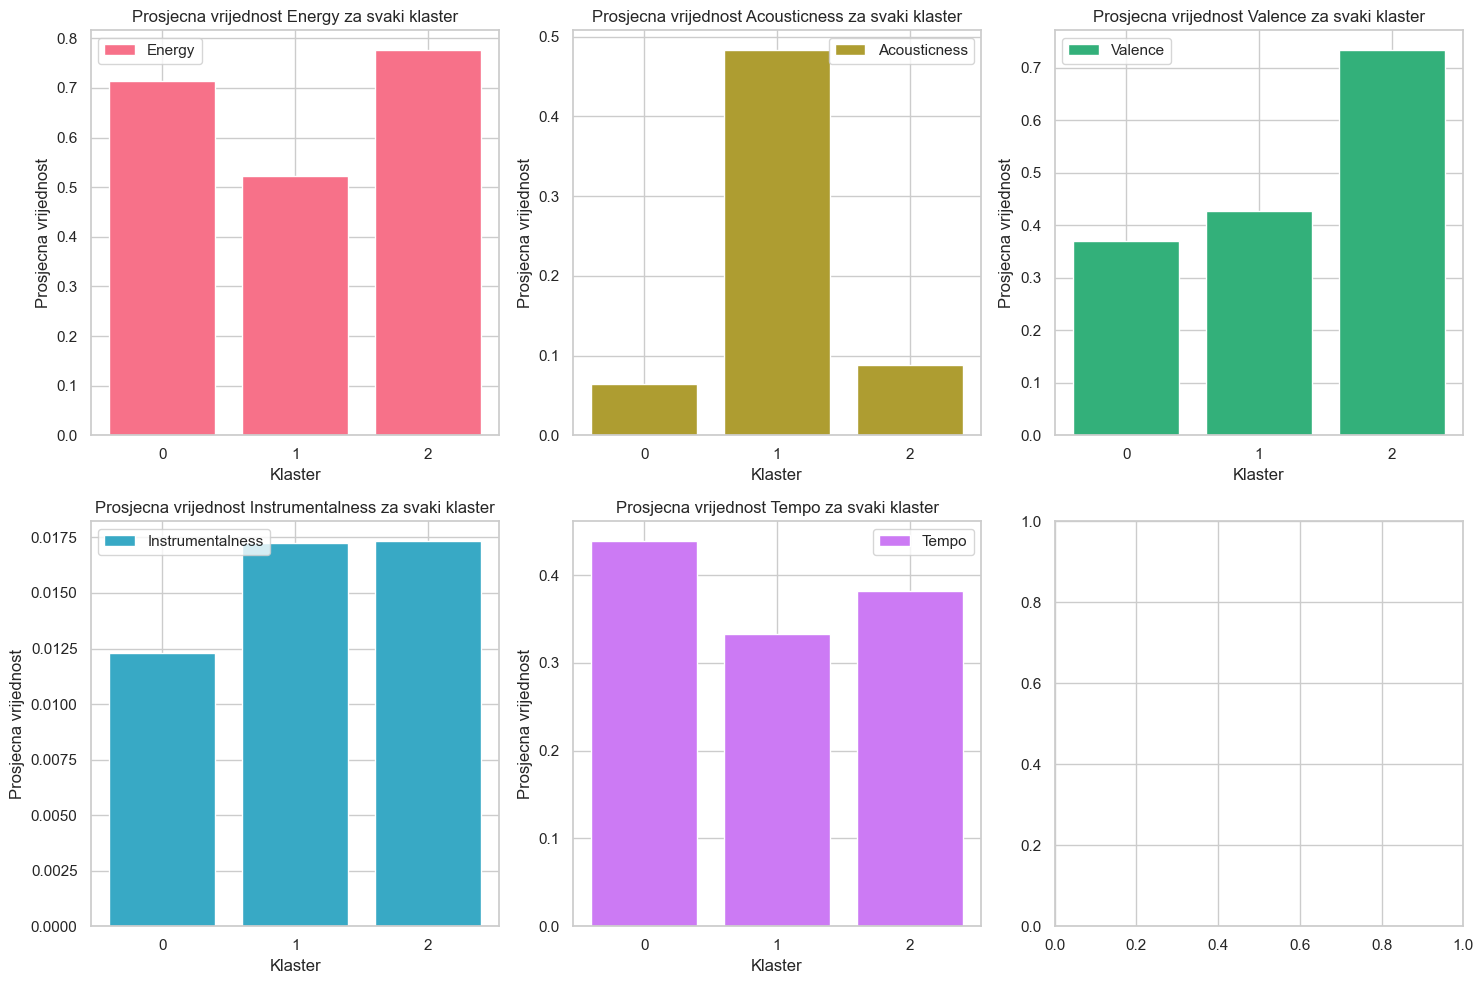

In [43]:
#Raspodjela karakteristika po klasterima

cluster_means = data.groupby('Cluster')[features].mean()

sns.set(style="whitegrid")
colors = sns.color_palette("husl", len(features))

num_cols = min(len(features), 3)
num_rows = (len(features) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*5))

for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    ax.bar(cluster_means.index, cluster_means[feature], color=colors[i], label=feature)
    ax.set_xlabel('Klaster')
    ax.set_ylabel('Prosjecna vrijednost')
    ax.set_title(f'Prosjecna vrijednost {feature} za svaki klaster')
    ax.set_xticks(cluster_means.index) 
    ax.set_xticklabels(cluster_means.index)
    ax.legend()


plt.tight_layout()
plt.show()

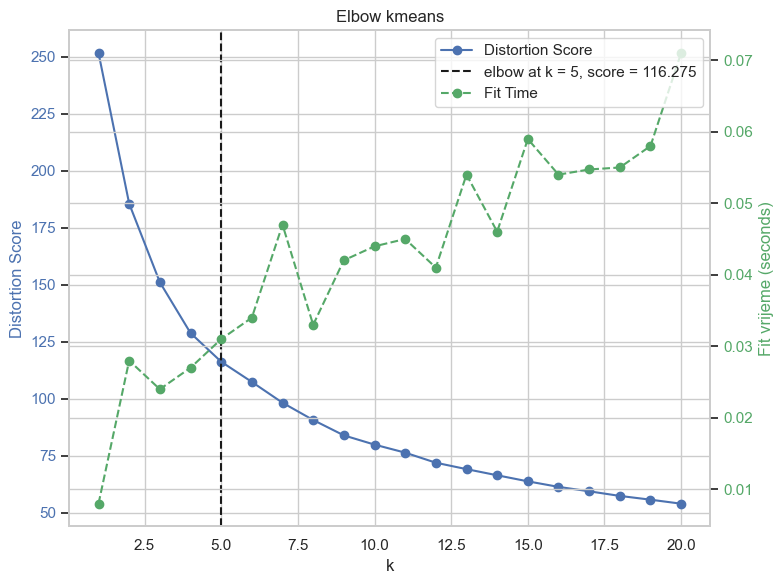

Optimalan broj klastera: 5


In [44]:
#Elbow metoda

distortion_scores = []
fit_times = []

for i in range(1, 21):
    start_time = time.time()
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10)
    kmeans.fit(X)
    end_time = time.time()
    distortion_scores.append(kmeans.inertia_)
    fit_times.append(end_time - start_time)

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(range(1, 21), distortion_scores, 'b-o', label='Distortion Score')
ax1.set_xlabel('k')
ax1.set_ylabel('Distortion Score', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Elbow kmeans')

kneedle = KneeLocator(range(1, 21), distortion_scores, curve='convex', direction='decreasing')
optimal_clustersEL = kneedle.elbow
ax1.axvline(x=optimal_clustersEL, color='k', linestyle='--', label=f'elbow at k = {optimal_clustersEL}, score = {distortion_scores[optimal_clustersEL-1]:.3f}')

ax2 = ax1.twinx()
ax2.plot(range(1, 21), fit_times, 'g--o', label='Fit Time')
ax2.set_ylabel('Fit vrijeme (seconds)', color='g')
ax2.tick_params(axis='y', labelcolor='g')
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.grid(True)
plt.show()
print(f"Optimalan broj klastera: {optimal_clustersEL}")

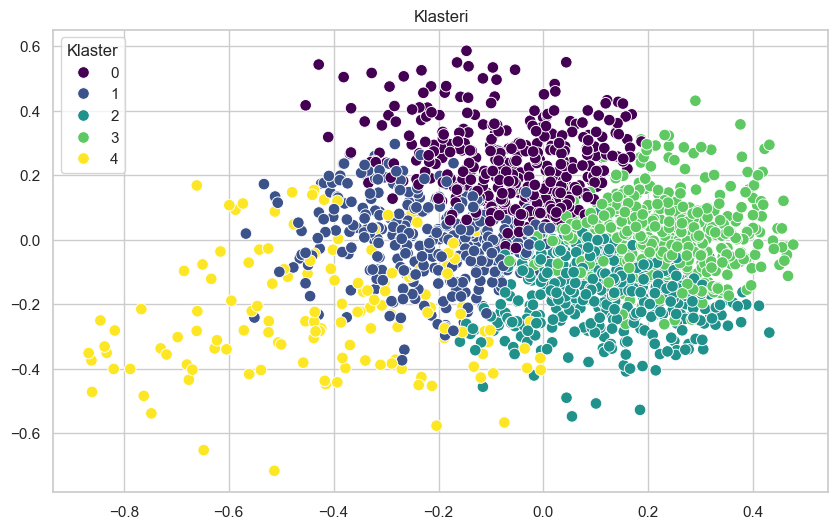

In [45]:
#Klasteri

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=optimal_clustersEL,init='k-means++',n_init=10)
clusters = kmeans.fit_predict(X)
data['ClusterE'] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['ClusterE'], palette='viridis', s=70)
plt.title('Klasteri')
plt.legend(title='Klaster')
plt.show()

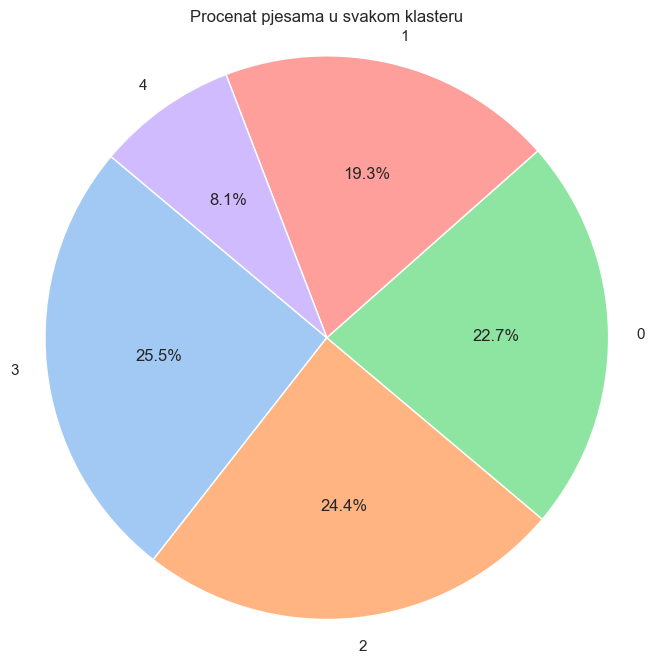

In [46]:
#Raposdjela pjesama

cluster_counts = data['ClusterE'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel", len(cluster_counts)))
plt.title('Procenat pjesama u svakom klasteru')
plt.axis('equal')
plt.show()

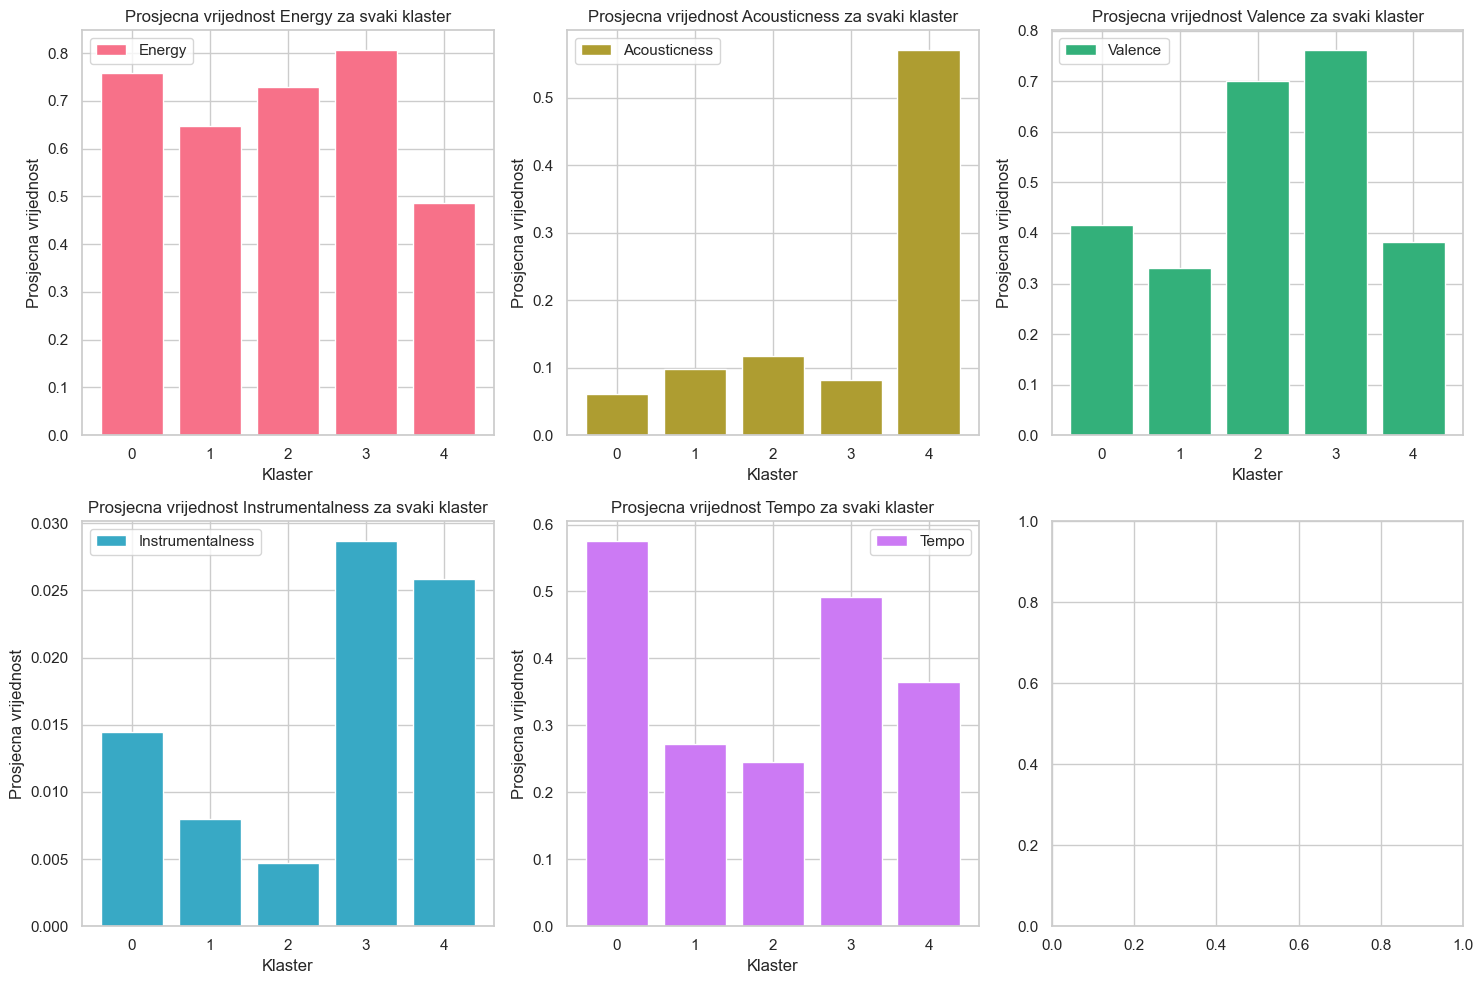

In [47]:
#Raspodjela karakteristika po klasterima

cluster_means = data.groupby('ClusterE')[features].mean()

sns.set(style="whitegrid")
colors = sns.color_palette("husl", len(features))

num_cols = min(len(features), 3)
num_rows = (len(features) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*5))

for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    ax.bar(cluster_means.index, cluster_means[feature], color=colors[i], label=feature)
    ax.set_xlabel('Klaster')
    ax.set_ylabel('Prosjecna vrijednost')
    ax.set_title(f'Prosjecna vrijednost {feature} za svaki klaster')
    ax.set_xticks(cluster_means.index) 
    ax.set_xticklabels(cluster_means.index)
    ax.legend()


plt.tight_layout()
plt.show()

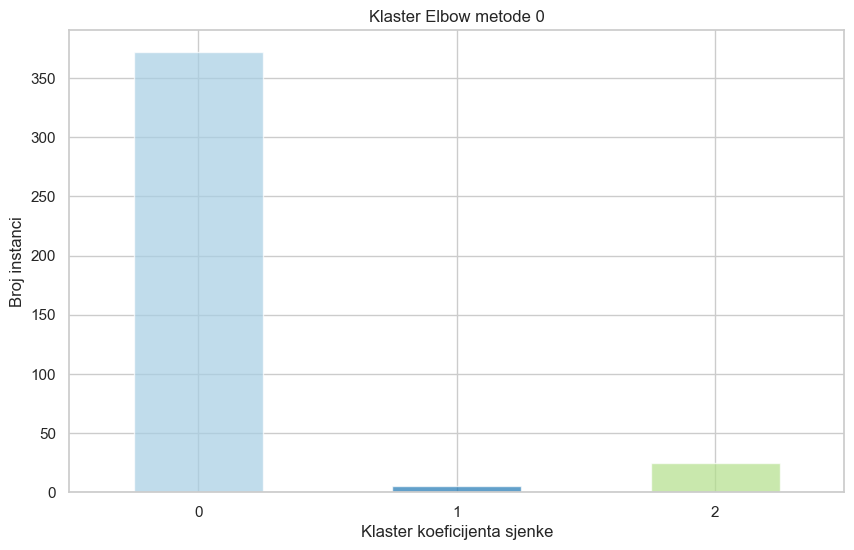

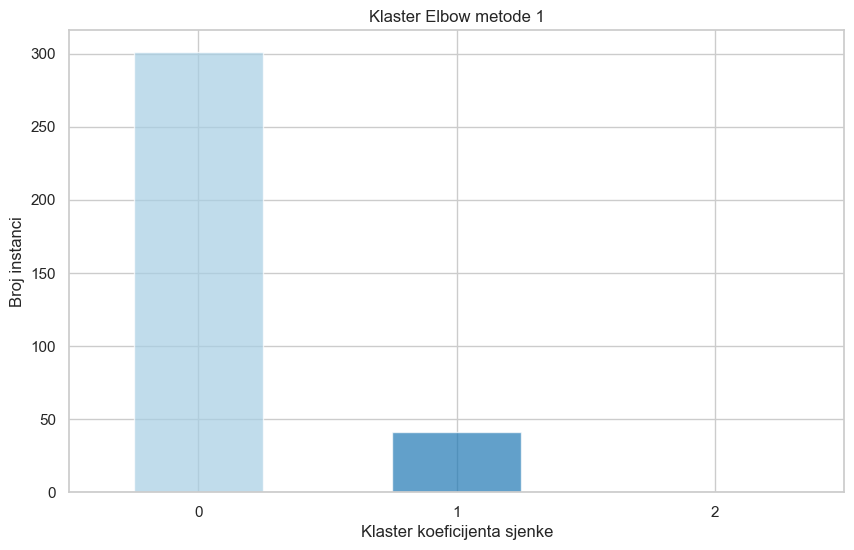

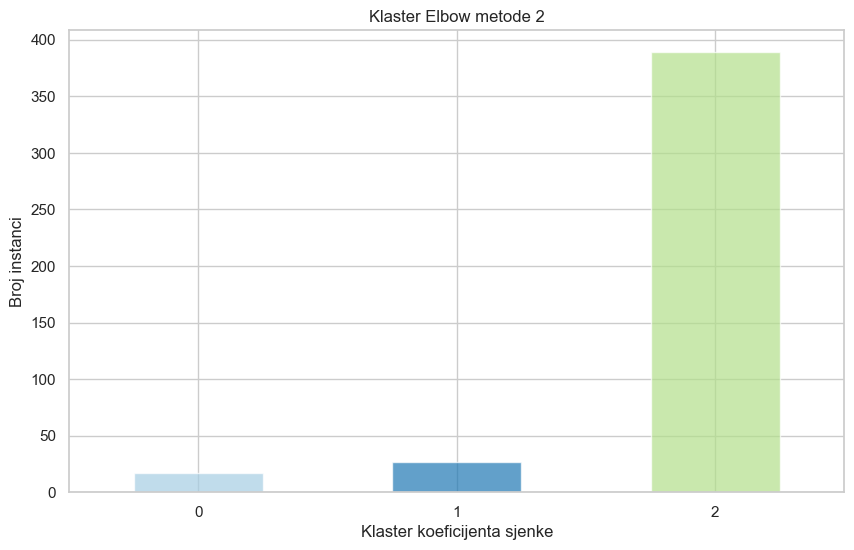

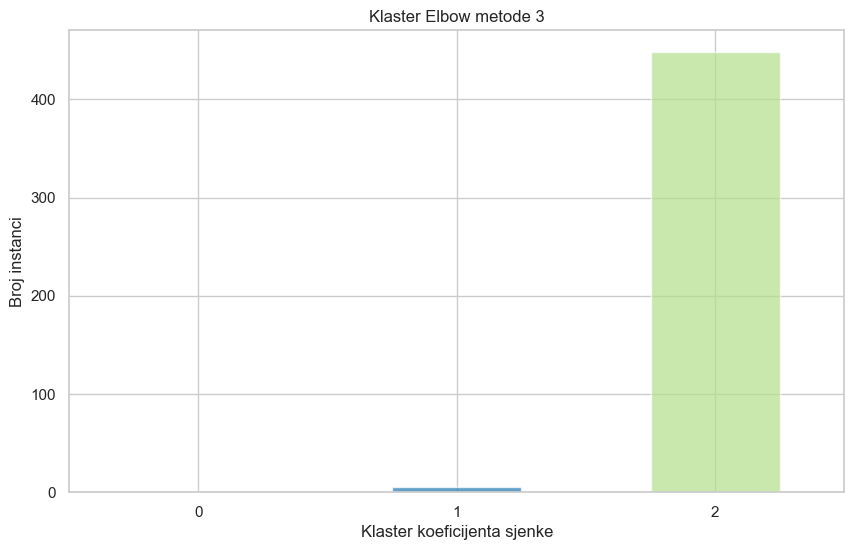

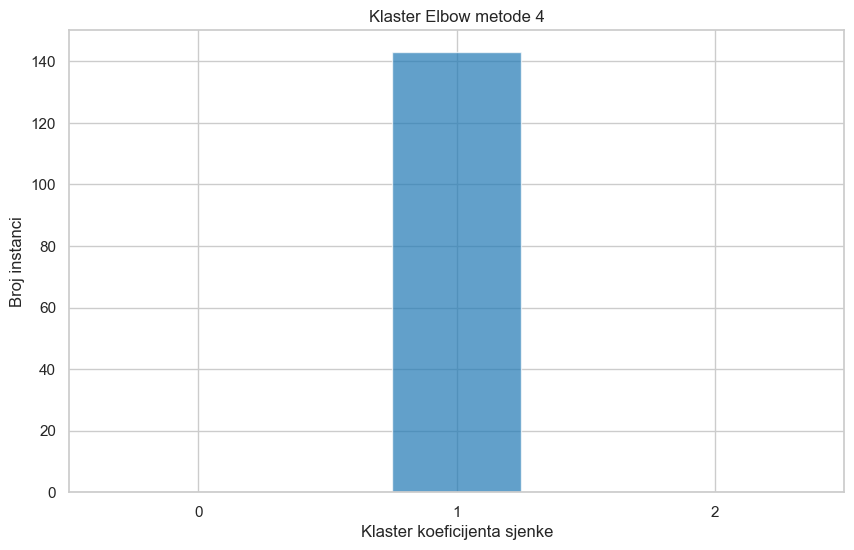

In [48]:
#Grupisanje podataka po ClusterE i Cluster
grouped = data.groupby(['ClusterE', 'Cluster']).size().unstack(fill_value=0)

for clusterE, row in grouped.iterrows():
    plt.figure(figsize=(10, 6))
    row.plot(kind='bar', color=plt.cm.Paired.colors, alpha=0.7)
    plt.title(f'Klaster Elbow metode {clusterE}')
    plt.xlabel('Klaster koeficijenta sjenke')
    plt.ylabel('Broj instanci')
    plt.xticks(rotation=0)
    plt.show()

In [49]:
sorted_data = data.sort_values(by=['Cluster', 'Popularity'], ascending=[True, False])
grouped_data = sorted_data.groupby('Cluster')

top_songs_per_cluster = {}
for cluster, group in grouped_data:
    top_songs_per_cluster[cluster] = group.head(7)

for cluster, top_songs in top_songs_per_cluster.items():
    print(f"\nCluster {cluster}:")
    print(top_songs[['Song', 'Artist','Popularity']])



Cluster 0:
                  Song             Artist  Popularity
1188   Sweater Weather  The Neighbourhood          89
162   'Till I Collapse             Eminem          85
1350      Daddy Issues  The Neighbourhood          85
1510           Perfect         Ed Sheeran          85
1349         The Hills         The Weeknd          84
1424         One Dance              Drake          84
1503            No Lie          Sean Paul          84

Cluster 1:
                      Song          Artist  Popularity
1179          Another Love       Tom Odell          88
1600  lovely (with Khalid)   Billie Eilish          86
1207      Do I Wanna Know?  Arctic Monkeys          84
1261             All of Me     John Legend          84
1502          Shape of You      Ed Sheeran          84
1513                 Bored   Billie Eilish          84
1586          Lucid Dreams      Juice WRLD          84

Cluster 2:
                                          Song          Artist  Popularity
154              

In [50]:
cluster_means = data.groupby('ClusterE')[features].mean()
cluster_means

,Energy,Acousticness,Valence,Instrumentalness,Tempo
ClusterE,,,,,
0,0.759308,0.061711,0.414964,0.014434,0.575863
1,0.646515,0.097995,0.331480,0.007953,0.272366
2,0.729222,0.117658,0.700436,0.004740,0.244650
3,0.807225,0.081117,0.762230,0.028698,0.492065
4,0.486350,0.570804,0.381196,0.025864,0.364728


In [51]:
different_clusters = data[(data['Cluster'] ==3) & (data['ClusterE']==0)][['Song', 'Cluster', 'ClusterE']]

print(different_clusters)

Empty DataFrame
Columns: [Song, Cluster, ClusterE]
Index: []
